# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [14]:
#import necessary library
import time
import numpy as np
import os
import pandas as pd
import datetime
from skimage import io
from skimage.transform import resize
import random as rn
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dropout, Input, Dense, Flatten, TimeDistributed, BatchNormalization, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling3D, Conv3D, MaxPooling2D, ZeroPadding3D, GlobalAveragePooling2D, AveragePooling3D, AveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import LSTM, GRU

from tensorflow.keras import optimizers
from tensorflow.keras.regularizers import l2

from tensorflow.keras.applications import mobilenet
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications import EfficientNetB0

#from scipy.misc import imread, imresize
# from tensorflow.compat.v1.keras.backend import get_session, set_session
# from tensorflow.keras.backend import clear_session
# from tensorflow.compat.v1 import ConfigProto, Session
# import gc

We set the random seed so that the results don't vary drastically.

In [15]:
start = time.time()
np.random.seed(30)
rn.seed(30)
tf.random.set_seed(30)

### DATA LOAD

Update the below Cell block to Import the Dataset

We have used Google Drive to download the Data

In [16]:
# Importing the data from Google Drive
from google.colab import drive
## mount the Google Drive to Colab so we can fetch the dataset
drive.mount('/content/gdrive')

# Remove the existing Train/Test Data folder in case its already present in colab workspace
import shutil
try:
    shutil.rmtree('Project_data')
    print('removed folder')
except OSError as error:
    print('folder not found')

# Update this Path according to your google drive path
!unzip gdrive/MyDrive/Project_data.zip

Streaming output truncated to the last 5000 lines.
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00050.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00052.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00054.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00056.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00058.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00060.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00062.png  
   creating: Project_data/train/WIN_20180926_17_35_12_Pro_Thumbs_Down_new/
 extracting: Project_data/train/WIN_20180926_17_35_12_Pro_Thumbs_Down_new/WIN_20180926_17_35_12_Pro_00001.png  
 extracting: Project_data/t

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [17]:
train_doc = np.random.permutation(open('/content/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/Project_data/val.csv').readlines())

In [18]:
pd.DataFrame([row.replace('\n','').split(';') for row in train_doc[0:5]],columns=['directory_name','Classification','Code'])

,directory_name,Classification,Code
0,WIN_20180926_16_54_08_Pro_Right_Swipe_new,Right_Swipe_new,1
1,WIN_20180925_18_02_58_Pro_Thumbs_Down_new,Thumbs_Down_new,3
2,WIN_20180925_17_33_08_Pro_Left_Swipe_new,Left_Swipe_new,0
3,WIN_20180925_17_51_17_Pro_Thumbs_Up_new,Thumbs_Up_new,4
4,WIN_20180926_17_17_35_Pro_Left_Swipe_new,Left_Swipe_new,0


## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [19]:
# # Remove the existing Train/Test Data folder in case its already present in colab workspace
# import shutil
# try:
#     shutil.rmtree('model_init_2021-08-0418_31_01.115729')
#     print('removed folder')
# except OSError as error:
#     print('folder not found')

In [20]:
# x = 30
# y = 120
# z = 120
# img_idx = np.arange(5,28,2)

In [21]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [1,3,5,7,9,11,13,15,16,18,20,21,23,25,27,29]#create a list of image numbers you want to use for a particular video
    x = 30
    y = 120
    z = 120

    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = io.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    # Cropping the image by 10%
                    image = tf.image.central_crop(image,0.9)
                    
                    # resizing the image to 120x120
                    image = tf.image.resize(image,(y,z))
                    
                    batch_data[folder,idx,:,:,0:3] = image[:, :, 0:3]/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        # left_out_data = len(folder_list) % batch_size
        left_out_data = len(t) - (num_batches * batch_size) # calculate the number of remaining data points
        if left_out_data > 0:
            batch_data = np.zeros((left_out_data,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((left_out_data,5)) # batch_labels is the one hot representation of the output
            for folder in range(left_out_data): # iterate over the left_out_data
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = io.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    # Cropping the image by 10%
                    image = tf.image.central_crop(image,0.9)
                    
                    # resizing the image to 120x120
                    image = tf.image.resize(image,(y,z))
                    
                    batch_data[folder,idx,:,:,0:3] = image[:, :, 0:3]/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [22]:
# Initialize the model train parameters
curr_dt_time = datetime.datetime.now()
filtersize = (3,3,3)
dropout = 0.25
batch_size=30
input_shape = (30, 120, 120, 3)
nb_classes = 5

num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 30 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 30


In [23]:
# lets set the path for train and validation dataset
train_path = '/content/Project_data/train'
val_path = '/content/Project_data/val'

# generating the train and validation data using generators
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

### Lets define Generic Methods

In [24]:
# method to visualize the model training and validation accuracy/loss history
def plot_graph(history):
    
    # define figure size for subplots with 2 cols and a row
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    
    # plot train and validation loss
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])

    # plot train and validation accuracy
    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    
    # add legends for the subplots
    axes[0].legend(['loss','val_loss'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

In [25]:
# Method to set optimizer , compile the model and fit and train the model on the dataset for the given bacth size and epochs
def train_model(model, batch_size, num_epochs, train_generator, val_generator, optimizer = optimizers.Adam(), checkpoint_flag = False):

    # print batch size and num of epochs
    print("batch_size :"+str(batch_size))
    print("# of epoch :"+str(num_epochs))
    
    # Validating the optimizer
    if optimizer == None:
        optimizer = optimizers.Adam()

    # Lets compile the model with metrics of categorical accuracy and loss function as categorical crossentropy
    model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])

    # generate the model checkpoint.
    LR = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 2, cooldown = 1, verbose = 1)
    ES = EarlyStopping(monitor='val_loss', patience=30, verbose=1, mode='auto')
    if checkpoint_flag:
        # create a folder name based on timestamp for final model
        curr_dt_time = datetime.datetime.now()
        model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
        
        # create a directory
        if not os.path.exists(model_name):
            os.mkdir(model_name)
            
        # set the finalname for h5 file
        filepath = model_name + 'final_model.h5'
    
        # create checkpoint based on val_loss
        checkpoint = ModelCheckpoint(filepath, 
                                 monitor = 'val_loss', 
                                 verbose = 1, 
                                 save_best_only = True, 
                                 save_weights_only = False, 
                                 mode = 'auto', 
                                 save_freq = "epoch")
        callbacks_list = [checkpoint, ES, LR]
    else:
        callbacks_list = [ES, LR]

    # The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1


    # Let us now fit the model. This will start training the model and with the help of the 
    # checkpoints, you'll be able to save the model at the end of each epoch.
    # model.fit_generator() is deprecated hence using model.fit()
    model_history = model.fit(train_generator, steps_per_epoch = steps_per_epoch, epochs = num_epochs, verbose = 1, 
                callbacks = callbacks_list, validation_data = val_generator, 
                validation_steps = validation_steps, class_weight = None, workers = 1, initial_epoch = 0)


    return plot_graph(model_history)

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

## LETS BUILD A MODEL USING CONV2D + RNN

### Model 1 - Conv2D_RNN_LSTM

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_23 (TimeDis (None, 30, 118, 118, 16)  448       
_________________________________________________________________
time_distributed_24 (TimeDis (None, 30, 118, 118, 16)  64        
_________________________________________________________________
time_distributed_25 (TimeDis (None, 30, 59, 59, 16)    0         
_________________________________________________________________
time_distributed_26 (TimeDis (None, 30, 57, 57, 16)    2320      
_________________________________________________________________
time_distributed_27 (TimeDis (None, 30, 57, 57, 16)    64        
_________________________________________________________________
time_distributed_28 (TimeDis (None, 30, 28, 28, 16)    0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 30, 28, 28, 16)   

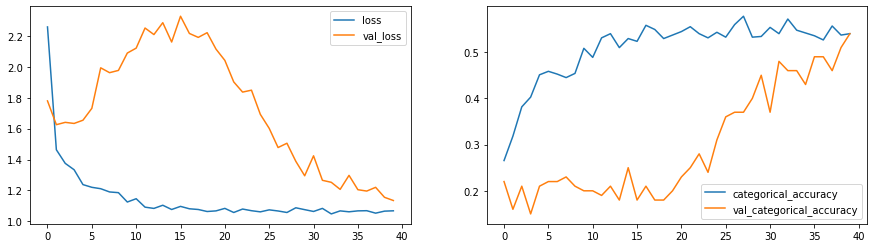

In [ ]:
# write your conv2D_RNN_model1 here
conv2D_RNN_model1 = Sequential()

conv2D_RNN_model1.add(TimeDistributed(Conv2D(16, (3, 3), activation='relu', padding='valid'), input_shape=input_shape))
conv2D_RNN_model1.add(TimeDistributed(BatchNormalization()))
conv2D_RNN_model1.add(TimeDistributed(AveragePooling2D((2, 2))))
conv2D_RNN_model1.add(TimeDistributed(Conv2D(16, (3,3), padding='valid', activation='relu')))
conv2D_RNN_model1.add(TimeDistributed(BatchNormalization()))
conv2D_RNN_model1.add(TimeDistributed(MaxPooling2D((2, 2))))
conv2D_RNN_model1.add(Dropout(0.05))

conv2D_RNN_model1.add(TimeDistributed(Conv2D(128, (3,3), padding='valid', activation='relu')))
conv2D_RNN_model1.add(TimeDistributed(BatchNormalization()))
conv2D_RNN_model1.add(TimeDistributed(MaxPooling2D((2, 2))))
conv2D_RNN_model1.add(TimeDistributed(Conv2D(128, (3,3), padding='same', activation='relu')))
conv2D_RNN_model1.add(TimeDistributed(BatchNormalization()))
conv2D_RNN_model1.add(TimeDistributed(AveragePooling2D((2, 2))))
conv2D_RNN_model1.add(Dropout(0.10))

conv2D_RNN_model1.add(TimeDistributed(Conv2D(512, (3,3), padding='same', activation='relu')))
conv2D_RNN_model1.add(TimeDistributed(BatchNormalization()))
conv2D_RNN_model1.add(TimeDistributed(MaxPooling2D((2, 2))))
conv2D_RNN_model1.add(TimeDistributed(Conv2D(512, (3,3), padding='same', activation='relu')))
conv2D_RNN_model1.add(TimeDistributed(BatchNormalization()))
conv2D_RNN_model1.add(Dropout(0.15))

conv2D_RNN_model1.add(TimeDistributed(Flatten()))

conv2D_RNN_model1.add(LSTM(1024, return_sequences=False))
conv2D_RNN_model1.add(Dropout(0.20))

conv2D_RNN_model1.add(Dense(nb_classes, activation='softmax'))
conv2D_RNN_model1.summary()

train_model(conv2D_RNN_model1, batch_size, 40, train_generator, val_generator, None)

### Observation:

Though the train and validation accuracy are the same, the accuracy is only 50% which is underfitting of data, hence lets reject this model

### Model 2 - Conv2D_RNN_GRU

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_5 (TimeDist (None, 30, 118, 118, 16)  448       
_________________________________________________________________
time_distributed_6 (TimeDist (None, 30, 118, 118, 16)  64        
_________________________________________________________________
time_distributed_7 (TimeDist (None, 30, 59, 59, 16)    0         
_________________________________________________________________
time_distributed_8 (TimeDist (None, 30, 57, 57, 16)    2320      
_________________________________________________________________
time_distributed_9 (TimeDist (None, 30, 57, 57, 16)    64        
_________________________________________________________________
time_distributed_10 (TimeDis (None, 30, 28, 28, 16)    0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 30, 28, 28, 16)   

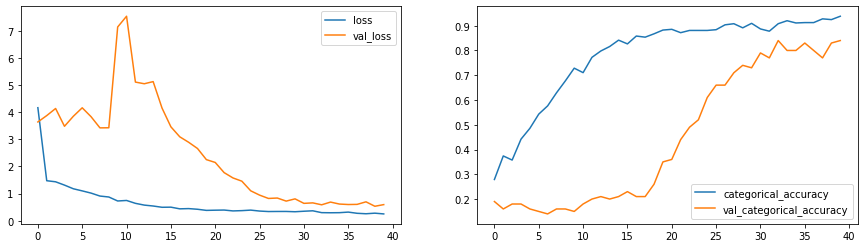

In [ ]:
# write your conv2D_RNN_model2 here
conv2D_RNN_model2 = Sequential()

conv2D_RNN_model2.add(TimeDistributed(Conv2D(16, (3, 3), activation='relu', padding='valid'), input_shape=input_shape))
conv2D_RNN_model2.add(TimeDistributed(BatchNormalization()))
conv2D_RNN_model2.add(TimeDistributed(AveragePooling2D((2, 2))))
conv2D_RNN_model2.add(TimeDistributed(Conv2D(16, (3,3), padding='valid', activation='relu')))
conv2D_RNN_model2.add(TimeDistributed(BatchNormalization()))
conv2D_RNN_model2.add(TimeDistributed(MaxPooling2D((2, 2))))
conv2D_RNN_model2.add(Dropout(0.05))

conv2D_RNN_model2.add(TimeDistributed(Conv2D(128, (3,3), padding='valid', activation='relu')))
conv2D_RNN_model2.add(TimeDistributed(BatchNormalization()))
conv2D_RNN_model2.add(TimeDistributed(MaxPooling2D((2, 2))))
conv2D_RNN_model2.add(TimeDistributed(Conv2D(128, (3,3), padding='same', activation='relu')))
conv2D_RNN_model2.add(TimeDistributed(BatchNormalization()))
conv2D_RNN_model2.add(TimeDistributed(AveragePooling2D((2, 2))))
conv2D_RNN_model2.add(Dropout(0.10))

conv2D_RNN_model2.add(TimeDistributed(Conv2D(512, (3,3), padding='same', activation='relu')))
conv2D_RNN_model2.add(TimeDistributed(BatchNormalization()))
conv2D_RNN_model2.add(TimeDistributed(MaxPooling2D((2, 2))))
conv2D_RNN_model2.add(TimeDistributed(Conv2D(512, (3,3), padding='same', activation='relu')))
conv2D_RNN_model2.add(TimeDistributed(BatchNormalization()))
conv2D_RNN_model2.add(Dropout(0.15))

conv2D_RNN_model2.add(TimeDistributed(Flatten()))

conv2D_RNN_model2.add(GRU(1024, return_sequences=False))
conv2D_RNN_model2.add(Dropout(0.20))

conv2D_RNN_model2.add(Dense(nb_classes, activation='softmax'))
conv2D_RNN_model2.summary()

train_model(conv2D_RNN_model2, batch_size, 40, train_generator, val_generator, None)

### Observation
    
Using the above model and on switching from LSTM to GRU we couls see a good increase in training and validation accuracy. This is a farily decent model and can learn better than model1 in capturing information.

### LETS SEE HOW THE CONV3D PERFROMS FOR THE GIVEN BATCH SIZE AND SEE IF IT THROWS OUT OF MEMORY ERROR

### Experimental Conv3D model for a batch size of 30 and tested on 5 epochs

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
activation (Activation)      (None, 30, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 30, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 15, 60, 60, 32)    13856     
_________________________________________________________________
activation_1 (Activation)    (None, 15, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 15, 60, 60, 32)   

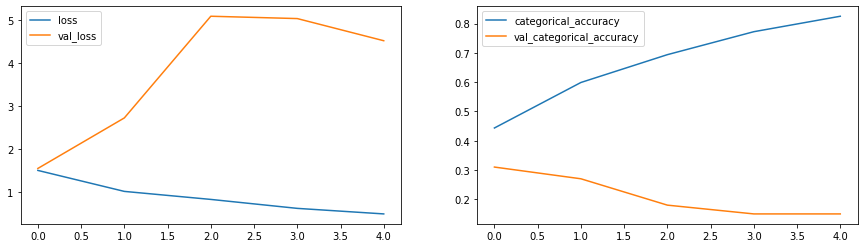

In [ ]:
def con3D_model1_initialise():
        Conv3D_model1 = Sequential()

        Conv3D_model1.add(Conv3D(16, (3,3,3), padding='same',input_shape = input_shape))
        Conv3D_model1.add(Activation('relu'))
        Conv3D_model1.add(BatchNormalization())
        Conv3D_model1.add(MaxPooling3D(pool_size=(2, 2, 2)))

        Conv3D_model1.add(Conv3D(32, (3,3,3), padding='same'))
        Conv3D_model1.add(Activation('relu'))
        Conv3D_model1.add(BatchNormalization())
        Conv3D_model1.add(MaxPooling3D(pool_size=(2, 2, 2)))

        Conv3D_model1.add(Conv3D(64, (3,3,3), padding='same'))
        Conv3D_model1.add(Activation('relu'))
        Conv3D_model1.add(BatchNormalization())
        Conv3D_model1.add(MaxPooling3D(pool_size=(2, 2, 2)))

        Conv3D_model1.add(Conv3D(128, (3,3,3), padding='same'))
        Conv3D_model1.add(Activation('relu'))
        Conv3D_model1.add(BatchNormalization())
        Conv3D_model1.add(MaxPooling3D(pool_size=(2, 2, 2)))

        Conv3D_model1.add(Flatten())
        Conv3D_model1.add(Dense(128, activation='relu'))
        Conv3D_model1.add(BatchNormalization())
        Conv3D_model1.add(Dropout(dropout))

        Conv3D_model1.add(Dense(64,activation='relu'))
        Conv3D_model1.add(BatchNormalization())
        Conv3D_model1.add(Dropout(dropout))

        Conv3D_model1.add(Dense(5,activation='softmax'))

        Conv3D_model1.summary()
        return Conv3D_model1
train_model(con3D_model1_initialise(), batch_size , 5, train_generator, val_generator, None)

### Experimentation outcome for batch size 

Based on different experimentational on the batch size, having a batch size of 30 utilized the GPU to its best performance without any Out of Memory issues, hence we stick to bacth size of 30

### NOW LETS STICK TO THIS CONV3D MODEL AND INCREASE THE EPOCHS SIZE TO 20

### Model 3 - Conv3D

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
activation_4 (Activation)    (None, 30, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 30, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 15, 60, 60, 32)    13856     
_________________________________________________________________
activation_5 (Activation)    (None, 15, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 15, 60, 60, 32)   

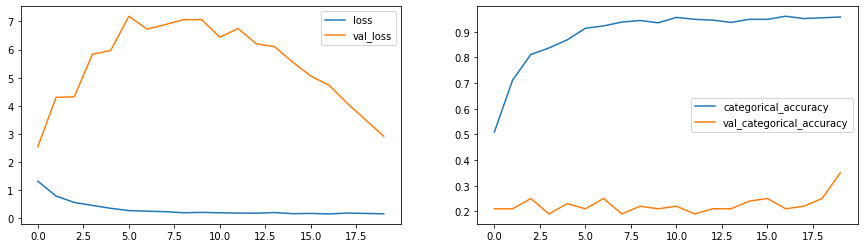

In [ ]:
train_model(con3D_model1_initialise(), batch_size , 20, train_generator, val_generator, None)

### Observation:

As the paramteres of Conv2D_model2 is pretty high , we are trying out Conv3D model with an epoch of 20 and considering this as a base model for Conv3D. Its pretty obvious that it leads to overfiting as the training accuracy is way to more than validation accuracy.

### INCREASE EPOCH TO 30

### Model 4 - Conv3D

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_8 (Conv3D)            (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
activation_8 (Activation)    (None, 30, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 30, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 15, 60, 60, 32)    13856     
_________________________________________________________________
activation_9 (Activation)    (None, 15, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 15, 60, 60, 32)   

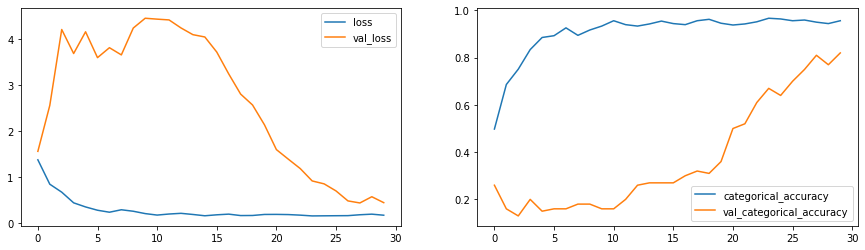

In [ ]:
train_model(con3D_model1_initialise(), batch_size , 30, train_generator, val_generator, None)

### Observation:

On increase the epochs to 30 we see the validtaion accuracy increase and the issue of over fitting is resolved when compared to Conv3D_model1.

## LETS USE KERNEL REGULARISER ON PREVIOUS CONV3D MODEL

### Model 5 - Conv3D

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 15, 60, 60, 32)    13856     
_________________________________________________________________
activation_3 (Activation)    (None, 15, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 60, 60, 32)   

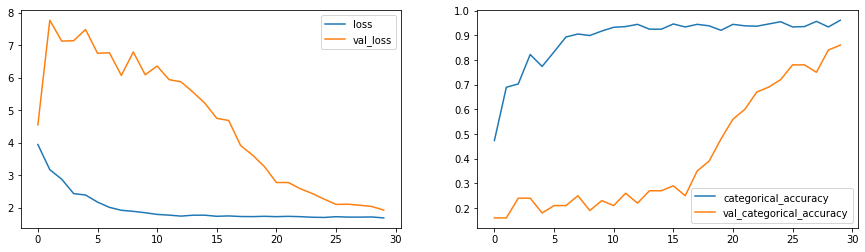

In [ ]:
Conv3D_model3 = Sequential()

Conv3D_model3.add(Conv3D(16, filtersize, padding='same', input_shape = input_shape))
Conv3D_model3.add(Activation('relu'))
Conv3D_model3.add(BatchNormalization())
Conv3D_model3.add(MaxPooling3D(pool_size=(2, 2, 2)))

Conv3D_model3.add(Conv3D(32, filtersize, padding='same'))
Conv3D_model3.add(Activation('relu'))
Conv3D_model3.add(BatchNormalization())
Conv3D_model3.add(MaxPooling3D(pool_size=(2, 2, 2)))

Conv3D_model3.add(Conv3D(64, filtersize, padding='same'))
Conv3D_model3.add(Activation('relu'))
Conv3D_model3.add(BatchNormalization())
Conv3D_model3.add(MaxPooling3D(pool_size=(2, 2, 2)))

Conv3D_model3.add(Conv3D(128, filtersize, padding='same'))
Conv3D_model3.add(Activation('relu'))
Conv3D_model3.add(BatchNormalization())
Conv3D_model3.add(MaxPooling3D(pool_size=(2, 2, 2)))

Conv3D_model3.add(Flatten())
Conv3D_model3.add(Dense(128,activation='relu', kernel_regularizer=l2(0.01)))
Conv3D_model3.add(BatchNormalization())
Conv3D_model3.add(Dropout(dropout))

Conv3D_model3.add(Dense(64,activation='relu'))
Conv3D_model3.add(BatchNormalization())
Conv3D_model3.add(Dropout(dropout))

Conv3D_model3.add(Dense(nb_classes, activation='softmax'))

Conv3D_model3.summary()
train_model(Conv3D_model3, batch_size , num_epochs, train_generator, val_generator, None)

### Observation:

As the difference between accuracy of Conv3D_model2 is around 12% lets add kernel_regularizer. We can see improvement in both train and validation accuracy has imporved when compared to Conv3D_model2.

As Validation accuracy of Conv3D_model3 is not above 90% lets try out transfer learning.

### LETS IMPLEMENT TRANSFER LEARNING USING MOBILENET

> Incase if the below model 6 or 7 throws Out Of Memory error in Jarvis, restart the kernel and run cells 1 to 15 and continue with the below models which thorws error

> This issues is not caused by batch size as we can process/train the model on following the above mentioned steps

## Model 6 - MobileNet + LSTM

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_10 (TimeDis (None, 30, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_11 (TimeDis (None, 30, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_12 (TimeDis (None, 30, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_13 (TimeDis (None, 30, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_14 (TimeDis (None, 30, 1024)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               590336    
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)              

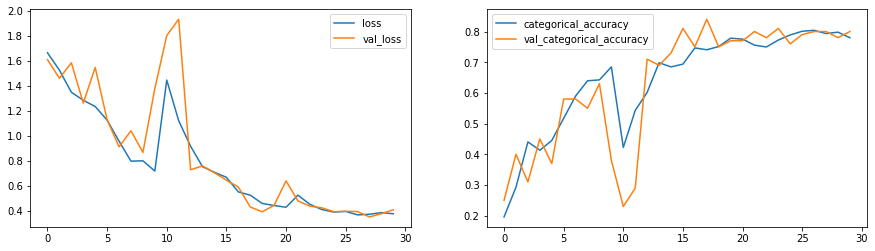

In [ ]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

modlelstm = Sequential()
modlelstm.add(TimeDistributed(mobilenet_transfer,input_shape=(input_shape)))

modlelstm.add(TimeDistributed(BatchNormalization()))
modlelstm.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))
modlelstm.add(TimeDistributed(Dropout(0.50)))
modlelstm.add(TimeDistributed(Flatten()))

modlelstm.add(LSTM(128))
modlelstm.add(Dropout(0.25))
modlelstm.add(Dense(128))
modlelstm.add(Activation('relu'))

modlelstm.add(Dense(5))
modlelstm.add(Activation('softmax'))
modlelstm.summary()

train_model(modlelstm, batch_size, num_epochs, train_generator, val_generator, None)

### Observation:

We see a drop in the Validation and Train Accuracy and it does not cross above 90%. Also the model does not perform better than above Conv3D_model3.

Lets try using GRU instead of LSTM and see if the accuracy improves

## Model 7 - MobileNet + GRU

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_5 (TimeDist (None, 30, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_6 (TimeDist (None, 30, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_7 (TimeDist (None, 30, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_8 (TimeDist (None, 30, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_9 (TimeDist (None, 30, 1024)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               443136    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)              

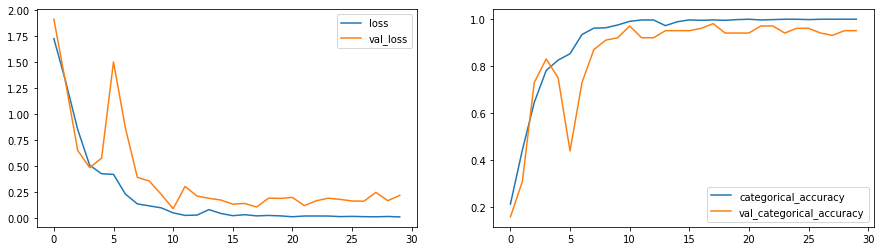

In [26]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

modlegru = Sequential()
modlegru.add(TimeDistributed(mobilenet_transfer,input_shape=(input_shape)))


modlegru.add(TimeDistributed(BatchNormalization()))
modlegru.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))
modlegru.add(TimeDistributed(Dropout(0.50)))
modlegru.add(TimeDistributed(Flatten()))

modlegru.add(GRU(128))
modlegru.add(Dropout(0.25))
modlegru.add(Dense(128))
modlegru.add(Activation('relu'))

modlegru.add(Dense(5))
modlegru.add(Activation('softmax'))
modlegru.summary()
train_model(modlegru, batch_size, num_epochs, train_generator, val_generator, None, True)

### Observation:

Using the above model and on  switching from LSTM to GRU, we see the modelgru gives the best results compared to all the above models and is thus the Best Model which we can use to test out the Test Dataset.

In [ ]:
end = time.time()
print(end - start)

9177.968208312988
